# Test 1 - Benchmarking FAISS vs ChromaDB for Movie Retrieval Tasks

### Importing Dependancies Environment Setup
use pip install as needed

In [ ]:
import os
import time
import pickle
import random
import numpy as np
import pandas as pd
import faiss
import chromadb
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer

###  Model and Index Mapping

In [ ]:

model_map = {
    "1": "sentence-transformers/multi-qa-MiniLM-L6-cos-v1",
    "2": "sentence-transformers/all-MiniLM-L6-v2",
    "3": "sentence-transformers/all-distilroberta-v1",
    "4": "sentence-transformers/distilbert-base-nli-stsb-mean-tokens",
    "5": "sentence-transformers/all-MiniLM-L12-v2",
}

index_map = {f"{i}": f"./../faiss_embeddings{i}/movie_index.faiss" for i in range(1, 6)}
id_list_map = {f"{i}": f"./../faiss_embeddings{i}/movie_ids.pkl" for i in range(1, 6)}

### Load Model and Index

In [18]:


def load_model_and_index(model_choice):
    model = SentenceTransformer(model_map[model_choice])
    index = faiss.read_index(index_map[model_choice])
    with open(id_list_map[model_choice], "rb") as f:
        id_list = pickle.load(f)
    return model, index, id_list


### Evaluation Functions
#### For FAISS models

In [ ]:
def run_faiss_model(model_choice, df, query_column, validate_column, top_k=10):
    model, index, id_list = load_model_and_index(model_choice)
    results = []
    start_time = time.time()

    for _, row in tqdm(df.iterrows(), total=len(df)):
        query = str(row[query_column])
        actual_id = str(row[validate_column])
        embedding = model.encode([query], normalize_embeddings=True).astype("float32")
        D, I = index.search(embedding, top_k)
        retrieved_ids = [str(id_list[idx]) for idx in I[0]]

        hit = 1 if actual_id in retrieved_ids else 0
        rank = retrieved_ids.index(actual_id) if hit else -1
        distance = D[0][rank] if hit else None

        results.append({
            "query": query,
            "actual_id": actual_id,
            "retrieved_ids": retrieved_ids,
            "hit": hit,
            "rank": rank,
            "distance": distance,
            "distance_scores": D[0].tolist(),
            "model": model_choice,
        })

    total_time = time.time() - start_time
    return results, total_time


#### For ChromaDB

In [ ]:
chroma_client = chromadb.PersistentClient(path="./../chromadb_client")
collection = chroma_client.get_collection(name="best_movies_database")

def run_chromadb_model(collection, df, query_column, validate_column, top_k=10):
    results = []
    start_time = time.time()

    for _, row in tqdm(df.iterrows(), total=len(df)):
        query = str(row[query_column])
        actual_id = str(row[validate_column])

        response = collection.query(query_texts=[query], n_results=top_k)
        retrieved_ids = [str(rid) for rid in response["ids"][0]]

        hit = 1 if actual_id in retrieved_ids else 0
        rank = retrieved_ids.index(actual_id) if hit else -1

        results.append({
            "query": query,
            "actual_id": actual_id,
            "retrieved_ids": retrieved_ids,
            "hit": hit,
            "rank": rank,
            "distance": None,
            "distance_scores": None,
            "model": "chromadb",
        })

    total_time = time.time() - start_time
    return results, total_time


### Function to generate advanced metrics

In [ ]:
def analyze_results(results):
    hits = [r for r in results if r["hit"] == 1]
    ranks = [r["rank"] for r in hits]
    distances = [r["distance"] for r in hits if r["distance"] is not None]
    reciprocal_ranks = [1 / (r + 1) for r in ranks]

    return {
        "accuracy": len(hits) / len(results),
        "mean_rank": np.mean(ranks) if ranks else None,
        "mean_distance": np.mean(distances) if distances else None,
        "mrr": np.mean(reciprocal_ranks) if reciprocal_ranks else None
    }

### Plotting Function

In [ ]:


def plot_summary_metrics(summary_df, title="Model Evaluation Metrics"):
    fig, ax = plt.subplots(2, 3, figsize=(20, 12))
    metrics = [
        ("accuracy", "Top-K Accuracy", 'steelblue'),
        ("mean_rank", "Mean Rank of Hit", 'indianred'),
        ("mrr", "Mean Reciprocal Rank (MRR)", 'slateblue'),
        ("mean_distance", "Mean Distance of Hit", 'darkgreen'),
        ("total_time_sec", "Total Time Taken (s)", 'darkorange'),
        ("avg_time_per_query_ms", "Avg Time per Query (ms)", 'mediumseagreen'),
    ]

    for i, (metric, label, color) in enumerate(metrics):
        row, col = divmod(i, 3)
        ax[row, col].bar(summary_df["model"], summary_df[metric], color=color)
        ax[row, col].set_title(label)
        ax[row, col].grid(True)

        for idx, value in enumerate(summary_df[metric]):
            ax[row, col].text(idx, value, f"{value:.2f}", ha='center', va='bottom')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


### Plotting Function

In [ ]:


def plot_summary_metrics(summary_df, title="Model Evaluation Metrics"):
    fig, ax = plt.subplots(2, 3, figsize=(20, 12))
    metrics = [
        ("accuracy", "Top-K Accuracy", 'steelblue'),
        ("mean_rank", "Mean Rank of Hit", 'indianred'),
        ("mrr", "Mean Reciprocal Rank (MRR)", 'slateblue'),
        ("mean_distance", "Mean Distance of Hit", 'darkgreen'),
        ("total_time_sec", "Total Time Taken (s)", 'darkorange'),
        ("avg_time_per_query_ms", "Avg Time per Query (ms)", 'mediumseagreen'),
    ]

    for i, (metric, label, color) in enumerate(metrics):
        row, col = divmod(i, 3)
        ax[row, col].bar(summary_df["model"], summary_df[metric], color=color)
        ax[row, col].set_title(label)
        ax[row, col].grid(True)

        for idx, value in enumerate(summary_df[metric]):
            ax[row, col].text(idx, value, f"{value:.2f}", ha='center', va='bottom')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


### Running Evaluations fucntion

In [ ]:
def evaluate_all_models(test_file, query_column, validate_column, top_k=10):
    df = pd.read_csv(test_file).dropna(subset=[query_column, validate_column]).reset_index(drop=True)
    summary = []

    for model_choice in model_map.keys():
        currently = model_map[model_choice]
        print(f"Evaluating model: {currently}")
        results, time_taken = run_faiss_model(model_choice, df, query_column, validate_column, top_k)
        stats = analyze_results(results)
        summary.append({
            "model": model_map[model_choice],
            "accuracy": stats["accuracy"],
            "mean_rank": stats["mean_rank"],
            "mean_distance": stats["mean_distance"],
            "mrr": stats["mrr"],
            "total_time_sec": time_taken,
            "avg_time_per_query_ms": (time_taken / len(df)) * 1000,
        })

    chroma_results, chroma_time = run_chromadb_model(collection, df, query_column, validate_column, top_k)
    chroma_stats = analyze_results(chroma_results)

    summary.append({
        "model": "ChromaDB",
        "accuracy": chroma_stats["accuracy"],
        "mean_rank": chroma_stats["mean_rank"],
        "mean_distance": chroma_stats["mean_distance"],
        "mrr": chroma_stats["mrr"],
        "total_time_sec": chroma_time,
        "avg_time_per_query_ms": (chroma_time / len(df)) * 1000,
    })

    return pd.DataFrame(summary)



Running model 1: sentence-transformers/multi-qa-MiniLM-L6-cos-v1


  0%|          | 0/27184 [00:00<?, ?it/s]


Running model 2: sentence-transformers/all-MiniLM-L6-v2


  0%|          | 0/27184 [00:00<?, ?it/s]


Running model 3: sentence-transformers/all-distilroberta-v1


  0%|          | 0/27184 [00:00<?, ?it/s]


Running model 4: sentence-transformers/distilbert-base-nli-stsb-mean-tokens


  0%|          | 0/27184 [00:00<?, ?it/s]


Running model 5: sentence-transformers/all-MiniLM-L12-v2


  0%|          | 0/27184 [00:00<?, ?it/s]


Running model: ChromaDB


  0%|          | 0/27184 [00:00<?, ?it/s]

posx and posy should be finite values
posx and posy should be finite values


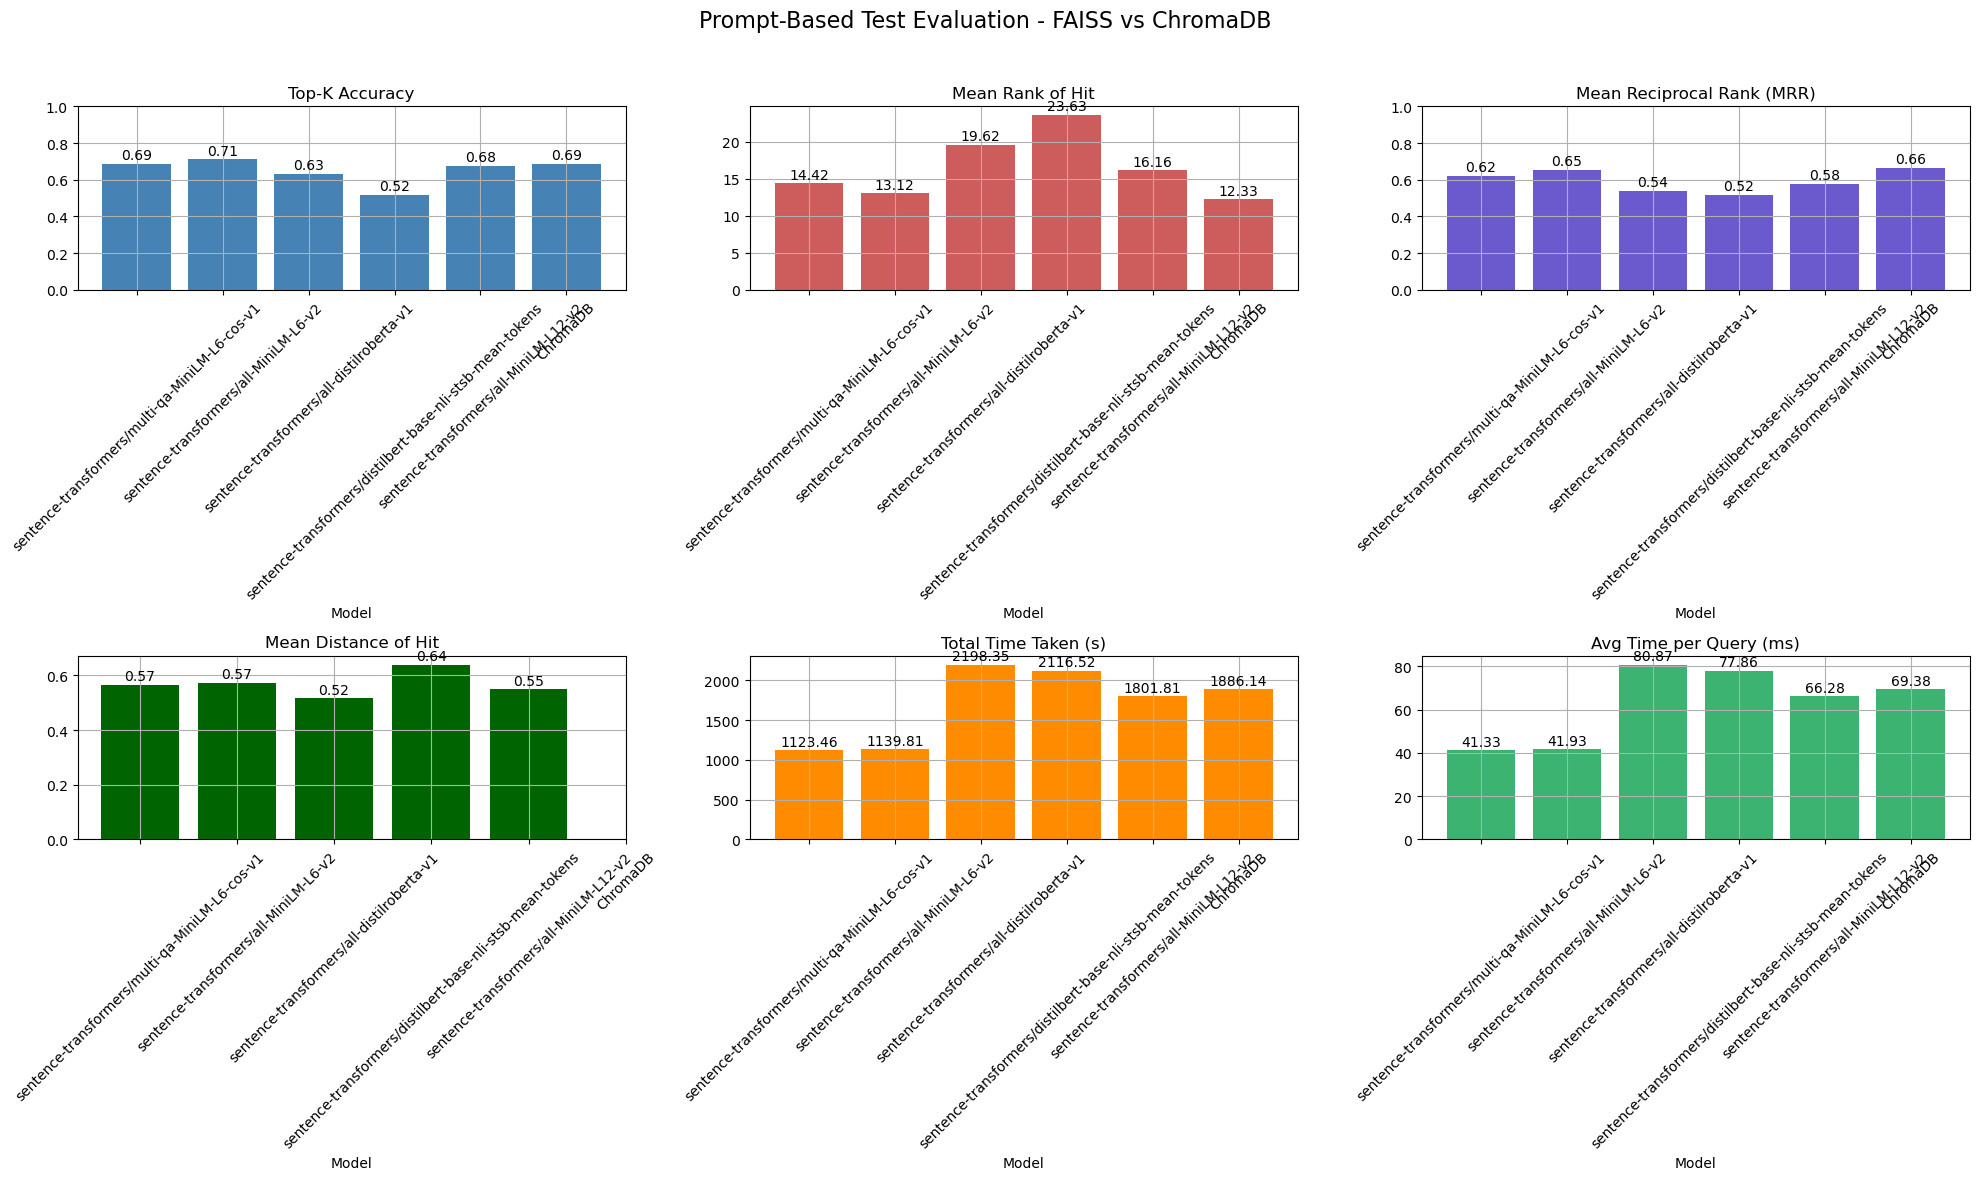

In [ ]:
fetched_overviews_27k_df = evaluate_all_models("../Vector_test_data/fetched_overview.csv", query_column="overview", validate_column="id", top_k=200)
plot_summary_metrics(fetched_overviews_27k_df, title="Prompt-Based Test Evaluation - Top 200")


Running model 1: sentence-transformers/multi-qa-MiniLM-L6-cos-v1


  0%|          | 0/1270 [00:00<?, ?it/s]


Running model 2: sentence-transformers/all-MiniLM-L6-v2


  0%|          | 0/1270 [00:00<?, ?it/s]


Running model 3: sentence-transformers/all-distilroberta-v1


  0%|          | 0/1270 [00:00<?, ?it/s]


Running model 4: sentence-transformers/distilbert-base-nli-stsb-mean-tokens


  0%|          | 0/1270 [00:00<?, ?it/s]


Running model 5: sentence-transformers/all-MiniLM-L12-v2


  0%|          | 0/1270 [00:00<?, ?it/s]


Running model: ChromaDB


  0%|          | 0/1270 [00:00<?, ?it/s]

posx and posy should be finite values
posx and posy should be finite values


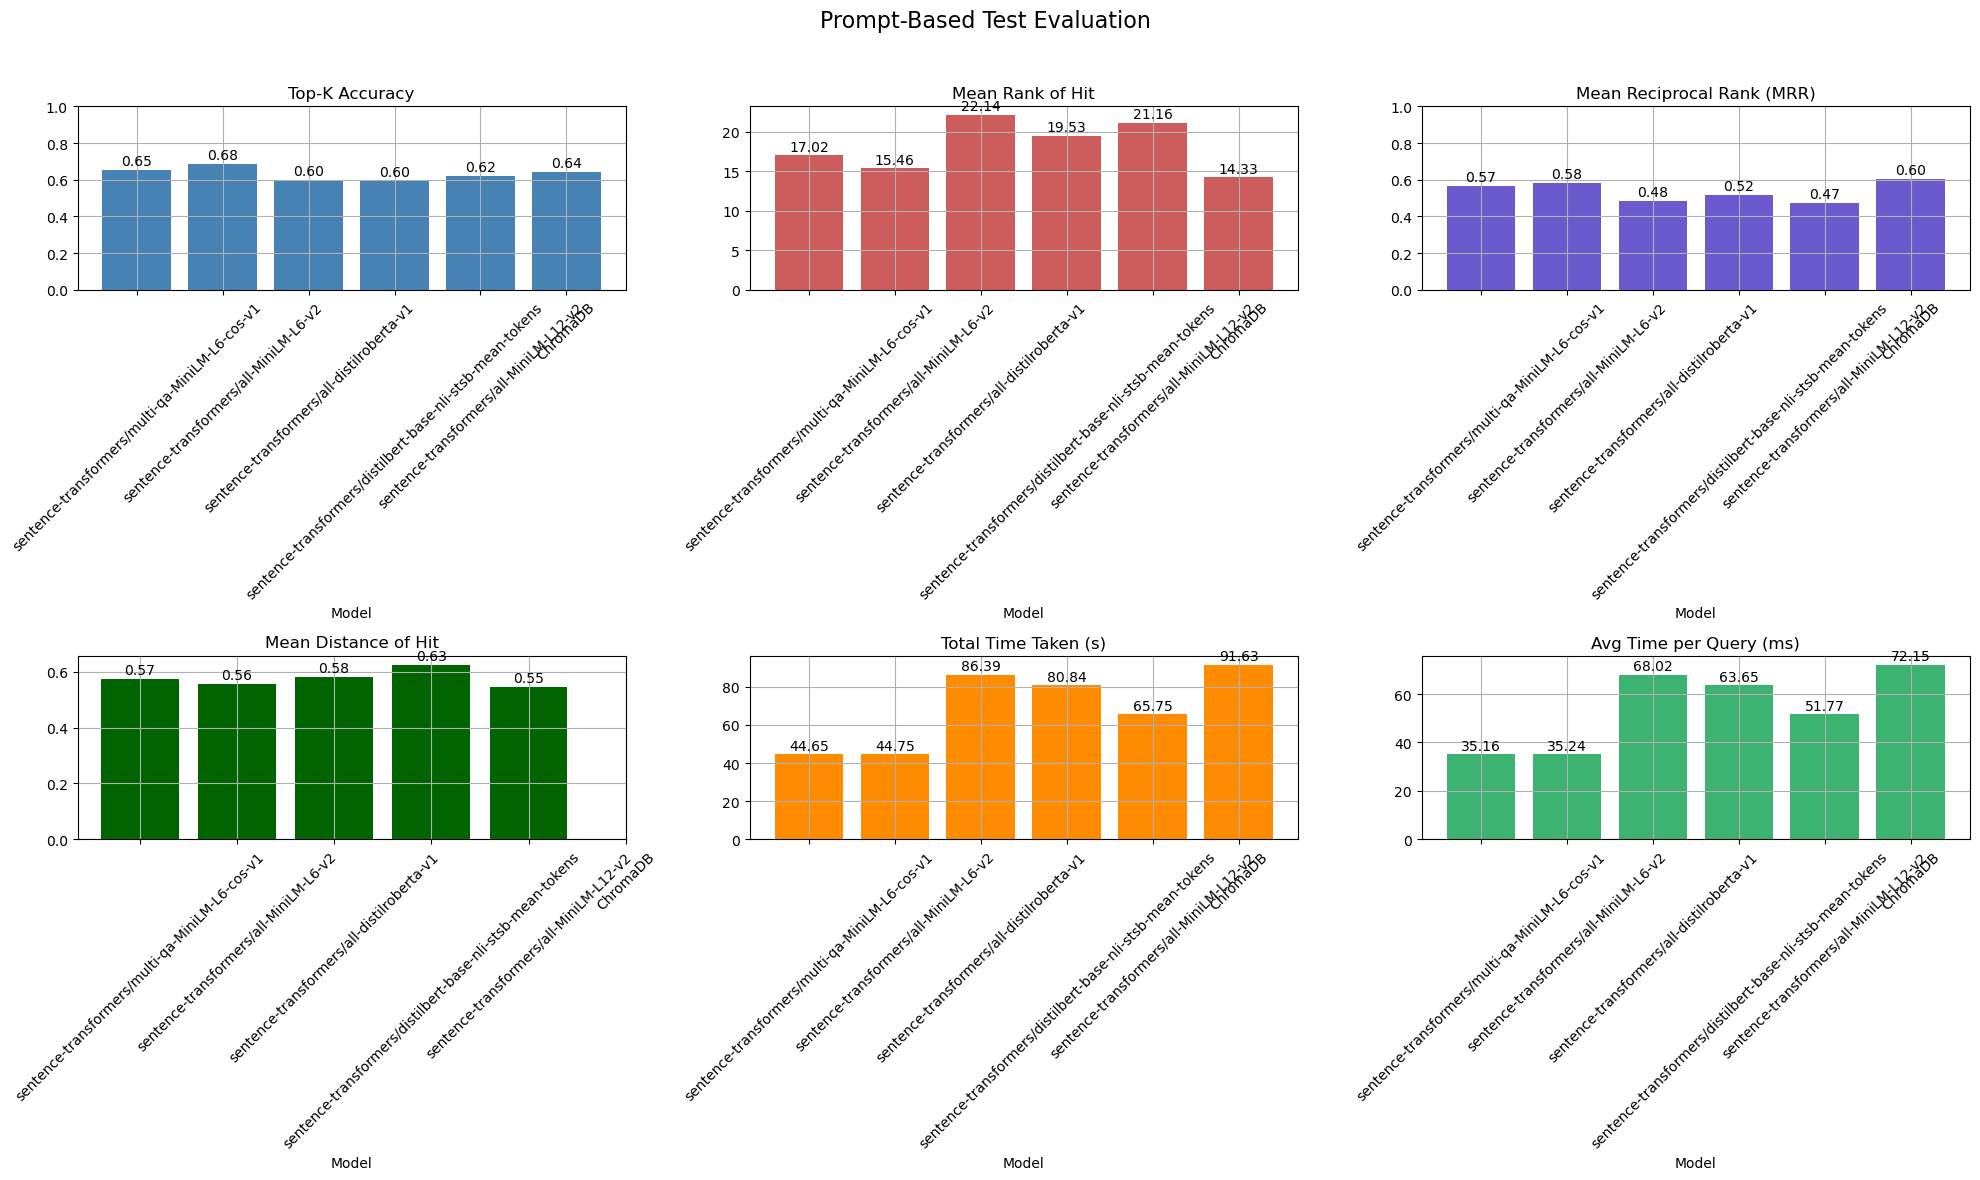

In [ ]:

handwritten_prompts_df = evaluate_all_models("../Vector_test_data/written_prompt.csv", query_column="prompts", validate_column="id", top_k=200)

plot_summary_metrics(handwritten_prompts_df, title="Prompt-Based Test Evaluation - Prompts Variant")